# Exercise Objective:

Build an image classifier in Keras that detects fashion items from low res images. The training set contains 60,000 grayscale images, each 28x28 pixels. There are 10 classes, all different clothes items.

In this work, you need to:

__Exercise 1__
1. Train a sequential, fully connected neural net to classify the clothes.
2. Assess the performance.

__Exercise 2__
3. Train a sequential, convolutional neural net to classify the clothes.
4. Compare the performance.

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Let's start by loading the fashion mnist dataset as we did back in week 9.

In [65]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Let's make sure the input pixel data is float64. We'll also split off some validation data.

In [66]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [67]:
X_train.dtype

dtype('float64')

In [68]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Let's see what the data looks like. Rerun to see more examples.

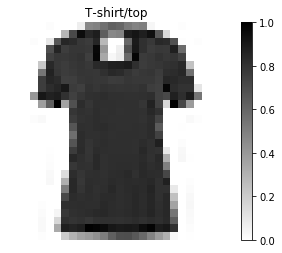

In [69]:
rand_idx = np.random.choice(range(X_train.shape[0]))
plt.imshow(X_train[rand_idx], cmap="binary")
plt.colorbar()
plt.axis('off')
plt.title(class_names[y_train[rand_idx]]);

## Exercise 1
Build the dense model.

In [70]:
## YOUR CODE HERE ##

In [71]:
img_size = (28, 28)
layer_sizes = (128, 64)
n_classes = 10

In [72]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential([
    Flatten(input_shape=img_size),
    Dense(layer_sizes[0], activation='selu',
          kernel_initializer='lecun_normal'),
    Dense(layer_sizes[1], activation='selu',
          kernel_initializer='lecun_normal'),
    Dense(n_classes, activation='softmax')
])

In [73]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [74]:
learning_rate = 0.005
n_epochs = 20

In [75]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(lr=learning_rate)

In [76]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint

save_cb = ModelCheckpoint("dense_fashion_model.h5",
                          save_best_only=True)

In [78]:
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[save_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 7s 124us/sample - loss: 0.5324 - accuracy: 0.8070 - val_loss: 0.4158 - val_accuracy: 0.8492
Epoch 2/20
55000/55000 [==============================] - 6s 116us/sample - loss: 0.4180 - accuracy: 0.8488 - val_loss: 0.4982 - val_accuracy: 0.8282
Epoch 3/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.3844 - accuracy: 0.8604 - val_loss: 0.3567 - val_accuracy: 0.8714
Epoch 4/20
55000/55000 [==============================] - 6s 113us/sample - loss: 0.3623 - accuracy: 0.8693 - val_loss: 0.3488 - val_accuracy: 0.8812
Epoch 5/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.3471 - accuracy: 0.8748 - val_loss: 0.3934 - val_accuracy: 0.8588
Epoch 6/20
55000/55000 [==============================] - 6s 115us/sample - loss: 0.3332 - accuracy: 0.8799 - val_loss: 0.3514 - val_accuracy: 0.8822
Epoch 7/20
55000/55000 [===========================

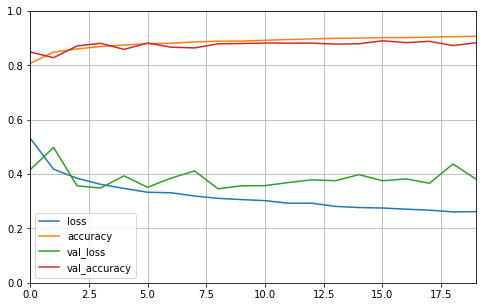

In [79]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

Evaluate the model.

In [80]:
from tensorflow.keras.models import load_model

model = load_model('dense_fashion_model.h5')

In [81]:
y_hat = model.predict_classes(X_test)

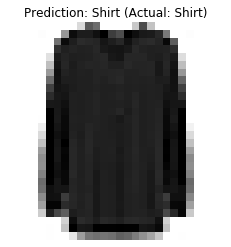

In [82]:
def plot_prediction():
    rand_idx = np.random.choice(range(X_test.shape[0]))
    image = X_test[rand_idx].squeeze()
    prediction = class_names[y_hat[rand_idx]]
    actual = class_names[y_test[rand_idx]]

    plt.imshow(image, cmap="binary")
    plt.axis('off')
    plt.title(f"Prediction: {prediction} (Actual: {actual})")

plot_prediction()

In [83]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.86      0.66      0.75      1000
           3       0.89      0.87      0.88      1000
           4       0.76      0.83      0.79      1000
           5       0.97      0.95      0.96      1000
           6       0.66      0.62      0.64      1000
           7       0.92      0.96      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Exercise 2

__NOTE:__
It is important to add a channel dimension to images going into convolutions, even if that dimension is simply 1 (greyscale). You can unsqueeze the numpy array like so:

In [42]:
X_train.shape

(55000, 28, 28)

In [43]:
X_train = X_train[..., None]
X_valid = X_valid[..., None]
X_test = X_test[..., None]

In [44]:
X_train.shape

(55000, 28, 28, 1)

Build the convolutional model.

In [45]:
## YOUR CODE HERE ##

In [46]:
img_size = (28, 28, 1)
layer_sizes = (128, 64)
n_filters = (64, 128, 256)
kernel_sizes = (7, 3, 3)
pool_size = 2
drop_prob = 0.5

In [47]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

model = Sequential([
    Conv2D(n_filters[0], kernel_sizes[0],
           activation='relu', padding='same',
           input_shape=img_size),
    MaxPooling2D(pool_size),
    Conv2D(n_filters[1], kernel_sizes[1],
           activation='relu', padding='same'),
     Conv2D(n_filters[1], kernel_sizes[1],
           activation='relu', padding='same'),
    MaxPooling2D(pool_size),
    Conv2D(n_filters[2], kernel_sizes[2],
           activation='relu', padding='same'),
    Conv2D(n_filters[2], kernel_sizes[2],
           activation='relu', padding='same'),
    MaxPooling2D(pool_size),
    Flatten(),
    Dense(layer_sizes[0], activation='relu'),
    Dense(layer_sizes[1], activation='relu'),
    Dropout(drop_prob),
    Dense(n_classes, activation='softmax')
])

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 256)        

In [49]:
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

save_cb = ModelCheckpoint("conv_fashion_model.h5",
                          save_best_only=True)

In [50]:
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[save_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 14s 257us/sample - loss: 0.5459 - accuracy: 0.8083 - val_loss: 0.3066 - val_accuracy: 0.8816
Epoch 2/20
55000/55000 [==============================] - 13s 236us/sample - loss: 0.3380 - accuracy: 0.8812 - val_loss: 0.2898 - val_accuracy: 0.8928
Epoch 3/20
55000/55000 [==============================] - 13s 237us/sample - loss: 0.2854 - accuracy: 0.8987 - val_loss: 0.2509 - val_accuracy: 0.9064
Epoch 4/20
55000/55000 [==============================] - 13s 237us/sample - loss: 0.2552 - accuracy: 0.9109 - val_loss: 0.2478 - val_accuracy: 0.9136
Epoch 5/20
55000/55000 [==============================] - 13s 237us/sample - loss: 0.2320 - accuracy: 0.9169 - val_loss: 0.2474 - val_accuracy: 0.9118
Epoch 6/20
55000/55000 [==============================] - 13s 235us/sample - loss: 0.2134 - accuracy: 0.9247 - val_loss: 0.2566 - val_accuracy: 0.9124
Epoch 7/20
55000/55000 [=====================

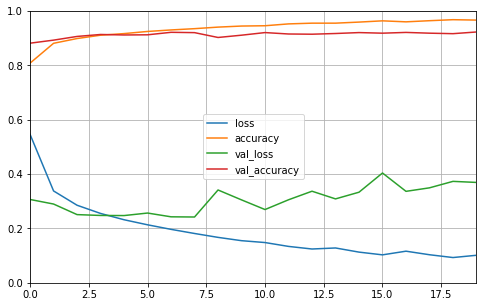

In [51]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

Evaluate the model.

In [52]:
## YOUR CODE HERE ##

In [53]:
model = load_model('conv_fashion_model.h5')
y_hat = model.predict_classes(X_test)

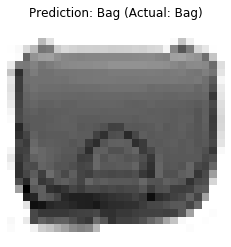

In [54]:
plot_prediction()

In [55]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.81      0.90      0.85      1000
           3       0.91      0.93      0.92      1000
           4       0.86      0.85      0.85      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.69      0.74      1000
           7       0.96      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

